<a href="https://colab.research.google.com/github/devansh-srv/BlockhouseQuant/blob/master/BlockHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Understanding the LOB working

In [ ]:
from collections import deque
from sortedcontainers import SortedDict

bid_book = SortedDict(lambda x:-x)
ask_book = SortedDict()

class Order():
    def __init__(self, price, size, side):
        self.price = price
        self.size = size
        self.side = side
    def add_order(self):
        book = bid_book if self.side == "buy" else ask_book
        if self.price not in book:
            book[self.price] = deque()
        book[self.price].append({'size':self.size,'price':self.price})



def mid_price():
  if not bid_book or not ask_book:
    return None
  return (bid_book.peekitem(0)[0] + ask_book.peekitem(0)[0]) / 2


def market_order(side, qty):
  filled = []
  book = ask_book if side == "buy" else bid_book
  while qty > 0 and book:
    price = book.peekitem(0)[0]
    queue = book[price]
    while qty > 0 and queue:
      order = queue[0]
      trade_size = min(qty,order['size'])
      order['size']-=trade_size
      qty-=trade_size
      filled.append((price,trade_size))
      if order['size'] == 0:
        queue.popleft()
    if not queue:
      del book[price]
  if qty>0:
    print("shares unfilled")
  return filled

def compute_slippage(trades,pre_mid,side):
  if not trades or pre_mid is None:
    return 0.0
  total_qty = sum(size for _,size in trades)
  total_val = sum(price*size for price,size in trades)
  avg_price = total_val/total_qty
  slippage = (avg_price-pre_mid) if side == "buy" else (pre_mid-avg_price)
  return slippage


Order(101.0, 5, "sell").add_order()
Order(101.1, 10, "sell").add_order()
Order(100.9, 6, "buy").add_order()
Order(100.8, 8, "buy").add_order()

print(bid_book)
print(ask_book)
pre_mid = mid_price()
print(pre_mid)
trades = market_order("buy",12)
print(trades)
print(compute_slippage(trades,pre_mid,"buy"))

SortedDict(<function <lambda> at 0x78b2732de3e0>, {100.9: deque([{'size': 6, 'price': 100.9}]), 100.8: deque([{'size': 8, 'price': 100.8}])})
SortedDict({101.0: deque([{'size': 5, 'price': 101.0}]), 101.1: deque([{'size': 10, 'price': 101.1}])})
100.95
[(101.0, 5), (101.1, 7)]
0.10833333333332007


extracting all MBP 10 files

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Data/CRWV.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/CRWV')
with ZipFile('/content/drive/MyDrive/Data/FROG.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/FROG')
with ZipFile('/content/drive/MyDrive/Data/SOUN.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/SOUN')

In [ ]:
!ls /content/

CRWV  CRWV.csv	drive  FROG  FROG.csv  sample_data  SOUN  SOUN.csv


In [ ]:
import pandas as pd
import os
tickers = ["SOUN","FROG","CRWV"]

In [ ]:
for ticker in tickers:
  path = os.path.join('/content',ticker)
  files = [f for f in os.listdir(path) if f.endswith('csv')]
  dfs = []
  for file in files:
    dfs.append(pd.read_csv(os.path.join(path,file)))
  pd.concat(dfs,ignore_index=True).to_csv(f'{ticker}.csv',index = False)

In [ ]:
df = pd.read_csv('CRWV.csv')
df.columns
#MBP-10

Index(['ts_event', 'ts_event.1', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'depth', 'price', 'size', 'flags', 'ts_in_delta',
       'sequence', 'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00',
       'bid_ct_00', 'ask_ct_00', 'bid_px_01', 'ask_px_01', 'bid_sz_01',
       'ask_sz_01', 'bid_ct_01', 'ask_ct_01', 'bid_px_02', 'ask_px_02',
       'bid_sz_02', 'ask_sz_02', 'bid_ct_02', 'ask_ct_02', 'bid_px_03',
       'ask_px_03', 'bid_sz_03', 'ask_sz_03', 'bid_ct_03', 'ask_ct_03',
       'bid_px_04', 'ask_px_04', 'bid_sz_04', 'ask_sz_04', 'bid_ct_04',
       'ask_ct_04', 'bid_px_05', 'ask_px_05', 'bid_sz_05', 'ask_sz_05',
       'bid_ct_05', 'ask_ct_05', 'bid_px_06', 'ask_px_06', 'bid_sz_06',
       'ask_sz_06', 'bid_ct_06', 'ask_ct_06', 'bid_px_07', 'ask_px_07',
       'bid_sz_07', 'ask_sz_07', 'bid_ct_07', 'ask_ct_07', 'bid_px_08',
       'ask_px_08', 'bid_sz_08', 'ask_sz_08', 'bid_ct_08', 'ask_ct_08',
       'bid_px_09', 'ask_px_09', 'bid_sz_09', 'ask_sz_09', 

In [ ]:
df.shape

(1882484, 74)

In [ ]:
df['action'].unique()

array(['C', 'A', 'T', 'F'], dtype=object)

In [ ]:
df['side'].unique()

array(['A', 'B', 'N'], dtype=object)

In [ ]:
import pandas as pd
import os
import json
def extract_l2_snapshot(row):
  bids = []
  for i in range(10):
    bid_px = row.get(f'bid_px_{i:02}',0)
    bid_sz = row.get(f'bid_sz_{i:02}',0)
    if pd.notna(bid_px) and pd.notna(bid_sz) and bid_px > 0 and bid_sz > 0:
      bids.append((bid_px,bid_sz))
  asks = []
  for i in range(10):
    ask_px = row.get(f'ask_px_{i:02}',0)
    ask_sz = row.get(f'ask_sz_{i:02}',0)
    if pd.notna(ask_px) and pd.notna(ask_sz) and ask_px > 0 and ask_sz > 0:
      asks.append((ask_px,ask_sz))
  return{
        "timestamp":row['ts_event'],
        "bids":bids,
        "asks":asks
    }

In [ ]:
tickers = ["SOUN","FROG","CRWV"]
for ticker in tickers:
  file_name = f'{ticker}.csv'
  print(f'Processing {file_name}')
  cols = [f'bid_px_{i:02}' for i in range(10)] + [f'bid_sz_{i:02}' for i in range(10)] + [f'ask_px_{i:02}' for i in range(10)] + [f'ask_sz_{i:02}' for i in range(10)] + ['ts_event']

  df = pd.read_csv(file_name,usecols=lambda col :  col in cols)
  df['ts_event_dt'] = pd.to_datetime(df['ts_event'],errors = 'coerce')
  df['minute'] = df['ts_event_dt'].dt.floor('min')
  df_min = df.sort_values('ts_event_dt').groupby('minute').tail(1).reset_index(drop = True)

  print(f"{len(df)} rows reduced to {len(df_min)} minute-snapshots.")

  with open(f"{ticker}_l2.jsonl", "w") as f:
        for _, row in df_min.iterrows():
            snap = extract_l2_snapshot(row)
            f.write(json.dumps(snap) + "\n")

print("Minute-resolution L2 extraction done!")

Processing SOUN.csv
5505097 rows reduced to 8190 minute-snapshots.
Processing FROG.csv
589053 rows reduced to 8162 minute-snapshots.
Processing CRWV.csv
1882484 rows reduced to 8189 minute-snapshots.
Minute-resolution L2 extraction done!


In [ ]:
def simulate_market_order(side,book,size):
  remain = size
  spent = 0.0
  filled = 0
  for px,sz in book:
    take = min(sz,remain)
    spent += (px*take)
    filled += take
    remain -= take
    if remain == 0:
      break
  if filled < size or size == 0:
    return None
  return spent/size

In [ ]:
def compute_slippage_curve(snapshots,side = "buy"):
  asks = snapshots['asks']
  bids = snapshots['bids']
  if not bids or not asks:
    return []
  best_bid = bids[0][0]
  best_ask = asks[0][0]
  pre_mid = (best_bid + best_ask)/2

  book = asks if side == "buy" else bids
  max_size = int(sum(sz for _,sz in book))
  if max_size < 500:
    return []
  steps = [1, 5, 10, 20, 30, 50, 100, 200, 500, 1000, 2000, 5000]
  sizes = [s for s in steps if s <= max_size]
  if max_size not in sizes:
    sizes.append(max_size)
  results = []
  for s in sizes:
    vwap = simulate_market_order(side,book,s)
    if vwap is not None:
      slippage = (vwap - pre_mid) if side == "buy" else (pre_mid - vwap)
      results.append({
                "timestamp": snapshots['timestamp'],
                "order_size": s,
                "vwap": vwap,
                "pre_mid": pre_mid,
                "slippage": slippage,
                "max_book_size": max_size
            })
  return results



In [ ]:
tickers = ["SOUN","FROG","CRWV"]
for ticker in tickers:
  results = []
  with open(f"{ticker}_l2.jsonl") as f:
    for line in f:
      snap = json.loads(line)
      per_min = compute_slippage_curve(snap,side = "buy")
      results.extend(per_min)
  # import pandas as pd
  df = pd.DataFrame(results)
  df.to_csv(f"{ticker}_slippage_curve.csv", index=False)

  print(f"Processed {len(df)} (minute x size) results for {ticker}. Example rows:")
  print(df.head())

Processed 106462 (minute x size) results for SOUN. Example rows:
                             timestamp  order_size  vwap  pre_mid  slippage  \
0  2025-04-03 13:30:59.965773808+00:00           1   8.1    8.085     0.015   
1  2025-04-03 13:30:59.965773808+00:00           5   8.1    8.085     0.015   
2  2025-04-03 13:30:59.965773808+00:00          10   8.1    8.085     0.015   
3  2025-04-03 13:30:59.965773808+00:00          20   8.1    8.085     0.015   
4  2025-04-03 13:30:59.965773808+00:00          30   8.1    8.085     0.015   

   max_book_size  
0          17475  
1          17475  
2          17475  
3          17475  
4          17475  
Processed 90374 (minute x size) results for FROG. Example rows:
                             timestamp  order_size  vwap  pre_mid  slippage  \
0  2025-04-03 13:30:54.573105705+00:00           1  31.5   31.285     0.215   
1  2025-04-03 13:30:54.573105705+00:00           5  31.5   31.285     0.215   
2  2025-04-03 13:30:54.573105705+00:00       

In [ ]:
df = pd.read_csv('FROG_slippage_curve.csv')
df.head()

,timestamp,order_size,vwap,pre_mid,slippage,max_book_size
0,2025-04-03 13:30:54.573105705+00:00,1,31.5,31.285,0.215,1366
1,2025-04-03 13:30:54.573105705+00:00,5,31.5,31.285,0.215,1366
2,2025-04-03 13:30:54.573105705+00:00,10,31.5,31.285,0.215,1366
3,2025-04-03 13:30:54.573105705+00:00,20,31.5,31.285,0.215,1366
4,2025-04-03 13:30:54.573105705+00:00,30,31.5,31.285,0.215,1366


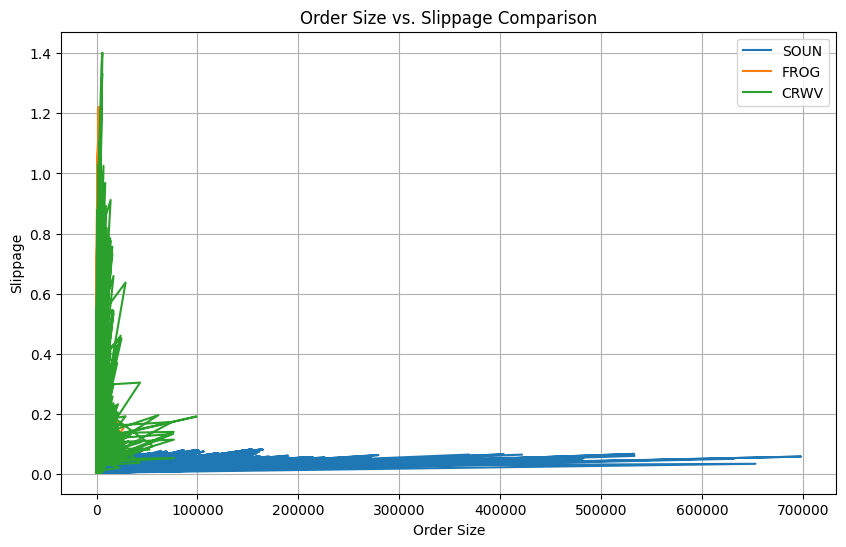

In [ ]:
import matplotlib.pyplot as plt

cols = ['order_size', 'slippage']
plt.figure(figsize=(10, 6))
for ticker in tickers:
  df = pd.read_csv(f'{ticker}_slippage_curve.csv', usecols=cols)
  plt.plot(df['order_size'], df['slippage'], label=ticker)
plt.xlabel('Order Size')
plt.ylabel('Slippage')
plt.title('Order Size vs. Slippage Comparison')
plt.legend()
plt.grid(True)
plt.show()


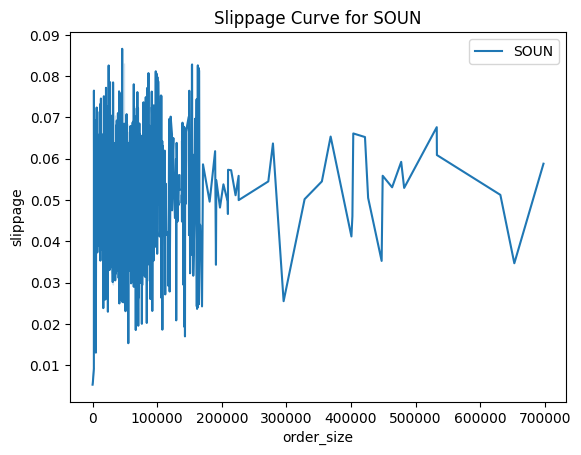

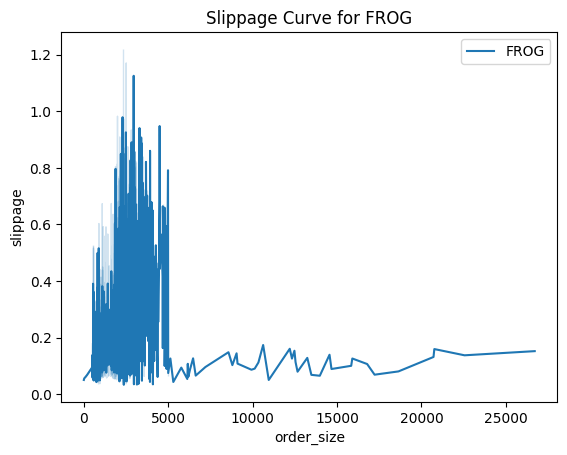

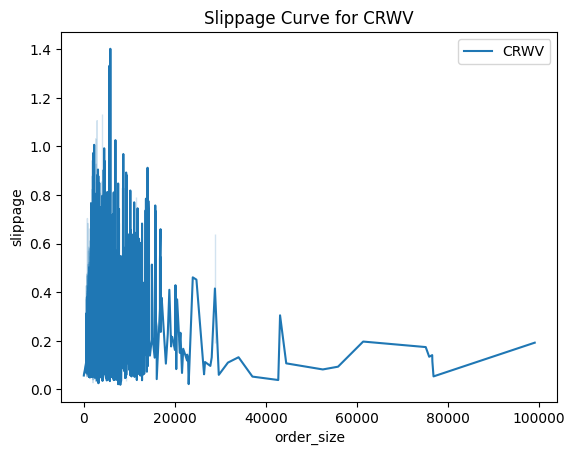

In [ ]:
import seaborn as sns
cols = ['order_size', 'slippage']
for ticker in tickers:
    df = pd.read_csv(f"{ticker}_slippage_curve.csv",usecols=cols)
    sns.lineplot(data=df, x="order_size", y="slippage", label=ticker)
    plt.title(f"Slippage Curve for {ticker}")
    plt.show()


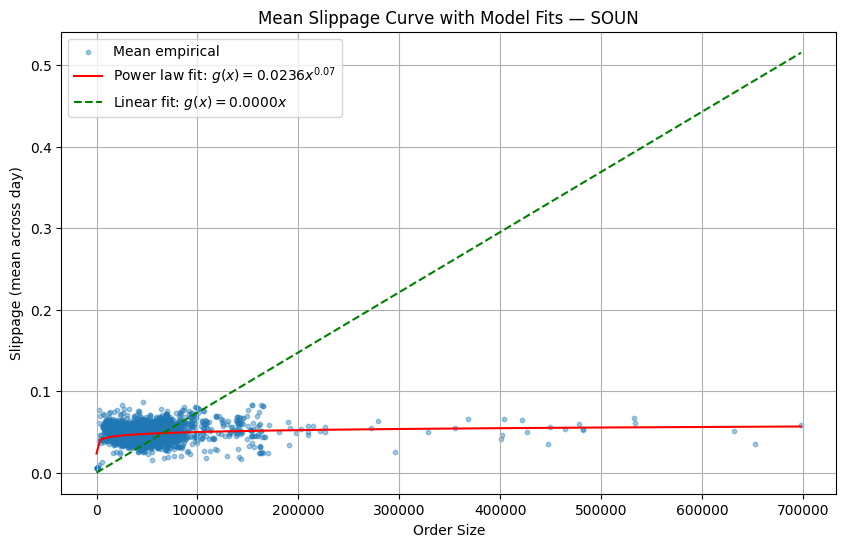

Ticker: SOUN
  Power-law fit:  k = 0.023610  alpha = 0.065 r2_score = 0.046602950560428735 pcov = [[ 8.06958789e-07 -3.22834507e-06]
 [-3.22834507e-06  1.29421041e-05]]
  Linear fit:     beta = 0.000001 pcov = [[3.66181457e-17]] r2_score = -13.587414237658622



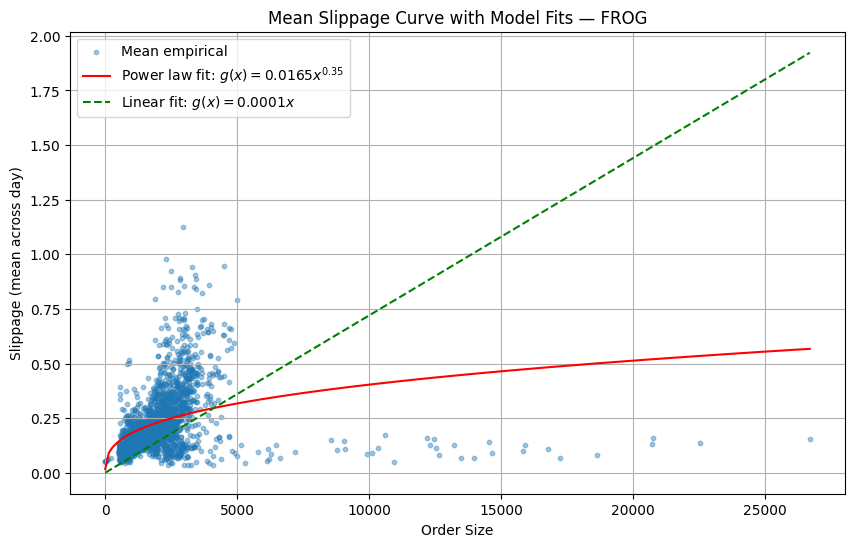

Ticker: FROG
  Power-law fit:  k = 0.016479  alpha = 0.347 r2_score = 0.14305321952248973 pcov = [[ 5.84796288e-06 -4.58163702e-05]
 [-4.58163702e-05  3.61237103e-04]]
  Linear fit:     beta = 0.000072 pcov = [[1.97568706e-12]] r2_score = -0.6760719732927816



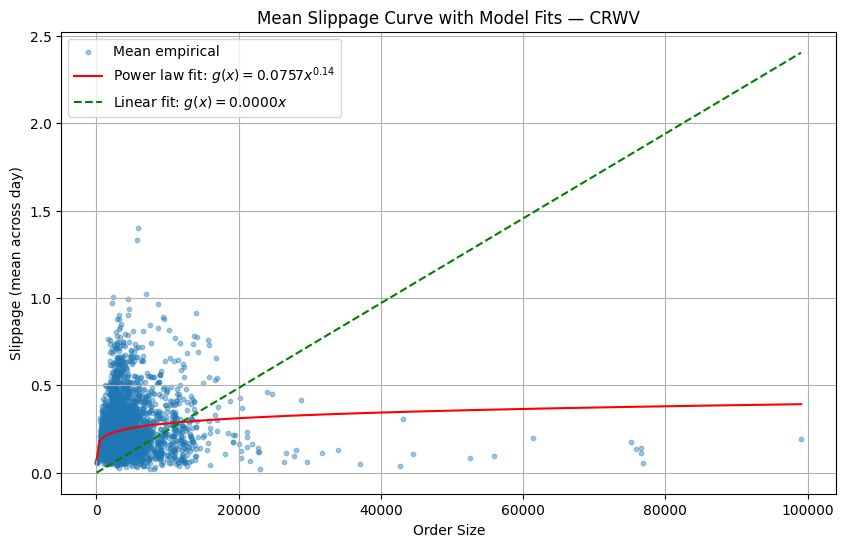

Ticker: CRWV
  Power-law fit:  k = 0.075738  alpha = 0.143 r2_score = 0.046345964394924555 pcov = [[ 4.75286440e-05 -7.67484882e-05]
 [-7.67484882e-05  1.25314871e-04]]
  Linear fit:     beta = 0.000024 pcov = [[3.49001036e-13]] r2_score = -1.5592258465257505



In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def power_law(x,k,alpha):
  return k*x**alpha
def linear(x,beta):
  return beta*x

for ticker in tickers:
  df = pd.read_csv(f'{ticker}_slippage_curve.csv',usecols=cols)
  grouped = df.groupby('order_size')['slippage'].mean().reset_index()
  x_data = grouped['order_size'].values
  y_data = grouped['slippage'].values
  mask = (x_data>0) & (y_data>0)
  x_data_fit = x_data[mask]
  y_data_fit = y_data[mask]


  popt,pcov = curve_fit(power_law,x_data_fit,y_data_fit,p0=[0.01,1])
  k_fit,alpha_fit = popt

  popt_lin, pcov_lin = curve_fit(linear, x_data_fit, y_data_fit)
  beta_fit = popt_lin[0]

  #eval
  r2_power = r2_score(y_data_fit,power_law(x_data_fit,k_fit,alpha_fit))
  r2_linear = r2_score(y_data_fit,linear(x_data_fit,beta_fit))


  plt.figure(figsize=(10, 6))
  plt.scatter(x_data_fit, y_data_fit, s=10, label="Mean empirical", alpha=0.4)
  x_dense = np.linspace(min(x_data), max(x_data), 200)
  plt.plot(x_dense, power_law(x_dense, k_fit, alpha_fit), color='red', label=f"Power law fit: $g(x)={k_fit:.4f} x^{{{alpha_fit:.2f}}}$")
  plt.plot(x_dense, linear(x_dense, beta_fit), color='green', linestyle='--', label=f"Linear fit: $g(x)={beta_fit:.4f} x$")
  plt.title(f"Mean Slippage Curve with Model Fits — {ticker}")
  plt.xlabel("Order Size")
  plt.ylabel("Slippage (mean across day)")
  plt.legend()
  plt.grid(True)
  plt.show()
  print(f"Ticker: {ticker}\n  Power-law fit:  k = {k_fit:.6f}  alpha = {alpha_fit:.3f} r2_score = {r2_power} pcov = {pcov}")
  print(f"  Linear fit:     beta = {beta_fit:.6f} pcov = {pcov_lin} r2_score = {r2_linear}\n")